In [1]:
from __future__ import print_function
from collections import OrderedDict
import os
import matplotlib.pyplot as plt
import torch
torch.manual_seed(0)

In [2]:
class Parse():
    def __init__(self):
        self.dataset = 'conll'
        self.result_path = 'neural_ner/results'
        self.usemodel = 'CNN_BiLSTM_CRF'
        self.worddim = 100
        self.pretrnd = 'wordvectors/glove.6B.100d.txt'
        self.reload = 0
        self.num_epochs = 10

opt=Parse()

In [3]:
from __future__ import print_function
import os
import re
import numpy as np
np.random.seed(0)
import codecs
import random
random.seed(0)

START_TAG = '<START>'
STOP_TAG = '<STOP>'

def get_name(parameters):
    """
    Generate a model name from its parameters.
    """
    l = []
    for k, v in parameters.items():
        if type(v) is str and "/" in v:
            l.append((k, v[::-1][:v[::-1].index('/')][::-1]))
        else:
            l.append((k, v))
    name = ",".join(["%s=%s" % (k, str(v).replace(',', '')) for k, v in l])
    return "".join(i for i in name if i not in "\/:*?<>|")


def set_values(name, param, pretrained):
    """
    Initialize a network parameter with pretrained values.
    We check that sizes are compatible.
    """
    param_value = param.get_value()
    if pretrained.size != param_value.size:
        raise Exception(
            "Size mismatch for parameter %s. Expected %i, found %i."
            % (name, param_value.size, pretrained.size)
        )
    param.set_value(np.reshape(
        pretrained, param_value.shape).astype(np.float32))


def create_dico(item_list):
    """
    Create a dictionary of items from a list of list of items.
    """
    assert type(item_list) is list
    dico = {}
    for items in item_list:
        for item in items:
            if item not in dico:
                dico[item] = 1
            else:
                dico[item] += 1
    return dico


def create_mapping(dico):
    """
    Create a mapping (item to ID / ID to item) from a dictionary.
    Items are ordered by decreasing frequency.
    """
    sorted_items = sorted(dico.items(), key=lambda x: (-x[1], x[0]))
    id_to_item = {i: v[0] for i, v in enumerate(sorted_items)}
    item_to_id = {v: k for k, v in id_to_item.items()}
    return item_to_id, id_to_item


def zero_digits(s):
    """
    Replace every digit in a string by a zero.
    """
    return re.sub('\d', '0', s)


def iob2(tags):
    """
    Check that tags have a valid IOB format.
    Tags in IOB1 format are converted to IOB2.
    """
    for i, tag in enumerate(tags):
        if tag == 'O':
            continue
        split = tag.split('-')
        if len(split) != 2 or split[0] not in ['I', 'B']:
            return False
        if split[0] == 'B':
            continue
        elif i == 0 or tags[i - 1] == 'O':  # conversion IOB1 to IOB2
            tags[i] = 'B' + tag[1:]
        elif tags[i - 1][1:] == tag[1:]:
            continue
        else:  # conversion IOB1 to IOB2
            tags[i] = 'B' + tag[1:]
    return True


def iob_iobes(tags):
    """
    IOB -> IOBES
    """
    new_tags = []
    for i, tag in enumerate(tags):
        if tag == 'O':
            new_tags.append(tag)
        elif tag.split('-')[0] == 'B':
            if i + 1 != len(tags) and \
               tags[i + 1].split('-')[0] == 'I':
                new_tags.append(tag)
            else:
                new_tags.append(tag.replace('B-', 'S-'))
        elif tag.split('-')[0] == 'I':
            if i + 1 < len(tags) and \
                    tags[i + 1].split('-')[0] == 'I':
                new_tags.append(tag)
            else:
                new_tags.append(tag.replace('I-', 'E-'))
        else:
            raise Exception('Invalid IOB format!')
    return new_tags


def iobes_iob(tags):
    """
    IOBES -> IOB
    """
    new_tags = []
    for i, tag in enumerate(tags):
        if tag.split('-')[0] == 'B':
            new_tags.append(tag)
        elif tag.split('-')[0] == 'I':
            new_tags.append(tag)
        elif tag.split('-')[0] == 'S':
            new_tags.append(tag.replace('S-', 'B-'))
        elif tag.split('-')[0] == 'E':
            new_tags.append(tag.replace('E-', 'I-'))
        elif tag.split('-')[0] == 'O':
            new_tags.append(tag)
        else:
            raise Exception('Invalid format!')
    return new_tags


def insert_singletons(words, singletons, p=0.5):
    """
    Replace singletons by the unknown word with a probability p.
    """
    new_words = []
    for word in words:
        if word in singletons and np.random.uniform() < p:
            new_words.append(0)
        else:
            new_words.append(word)
    return new_words


def pad_word_chars(words):
    """
    Pad the characters of the words in a sentence.
    Input:
        - list of lists of ints (list of words, a word being a list of char indexes)
    Output:
        - padded list of lists of ints
        - padded list of lists of ints (where chars are reversed)
        - list of ints corresponding to the index of the last character of each word
    """
    max_length = max([len(word) for word in words])
    char_for = []
    char_rev = []
    char_pos = []
    for word in words:
        padding = [0] * (max_length - len(word))
        char_for.append(word + padding)
        char_rev.append(word[::-1] + padding)
        char_pos.append(len(word) - 1)
    return char_for, char_rev, char_pos


def create_input(data, parameters, add_label, singletons=None):
    """
    Take sentence data and return an input for
    the training or the evaluation function.
    """
    words = data['words']
    chars = data['chars']
    if singletons is not None:
        words = insert_singletons(words, singletons)
    if parameters['cap_dim']:
        caps = data['caps']
    char_for, char_rev, char_pos = pad_word_chars(chars)
    input = []
    if parameters['word_dim']:
        input.append(words)
    if parameters['char_dim']:
        input.append(char_for)
        if parameters['char_bidirect']:
            input.append(char_rev)
        input.append(char_pos)
    if parameters['cap_dim']:
        input.append(caps)
    if add_label:
        input.append(data['tags'])
    return input

def char_mapping(sentences):
    """
    Create a dictionary and mapping of characters, sorted by frequency.
    """
    chars = ["".join([w[0] for w in s]) for s in sentences]
    dico = create_dico(chars)
    dico['<PAD>'] = 10000000
    # dico[';'] = 0
    char_to_id, id_to_char = create_mapping(dico)
    print("Found %i unique characters" % len(dico))
    return dico, char_to_id, id_to_char


def tag_mapping(sentences):
    """
    Create a dictionary and a mapping of tags, sorted by frequency.
    """
    tags = [[word[-1] for word in s] for s in sentences]
    dico = create_dico(tags)
    dico[START_TAG] = -1
    dico[STOP_TAG] = -2
    tag_to_id, id_to_tag = create_mapping(dico)
    print("Found %i unique named entity tags" % len(dico))
    return dico, tag_to_id, id_to_tag


def cap_feature(s):
    """
    Capitalization feature:
    0 = low caps
    1 = all caps
    2 = first letter caps
    3 = one capital (not first letter)
    """
    if s.lower() == s:
        return 0
    elif s.upper() == s:
        return 1
    elif s[0].upper() == s[0]:
        return 2
    else:
        return 3


def prepare_sentence(str_words, word_to_id, char_to_id, lower=False):
    """
    Prepare a sentence for evaluation.
    """
    def f(x): return x.lower() if lower else x
    words = [word_to_id[f(w) if f(w) in word_to_id else '<UNK>']
             for w in str_words]
    chars = [[char_to_id[c] for c in w if c in char_to_id]
             for w in str_words]
    caps = [cap_feature(w) for w in str_words]
    return {
        'str_words': str_words,
        'words': words,
        'chars': chars,
        'caps': caps
    }


def prepare_dataset(sentences, word_to_id, char_to_id, tag_to_id, lower=True):
    """
    Prepare the dataset. Return a list of lists of dictionaries containing:
        - word indexes
        - word char indexes
        - tag indexes
    """
    def f(x): return x.lower() if lower else x
    data = []
    for s in sentences:
        str_words = [w[0] for w in s]
        words = [word_to_id[f(w) if f(w) in word_to_id else '<UNK>']
                 for w in str_words]
        # Skip characters that are not in the training set
        chars = [[char_to_id[c] for c in w if c in char_to_id]
                 for w in str_words]
        caps = [cap_feature(w) for w in str_words]
        tags = [tag_to_id[w[-1]] for w in s]
        data.append({
            'str_words': str_words,
            'words': words,
            'chars': chars,
            'caps': caps,
            'tags': tags,
        })
    return data


def augment_with_pretrained(dictionary, ext_emb_path, words):
    """
    Augment the dictionary with words that have a pretrained embedding.
    If `words` is None, we add every word that has a pretrained embedding
    to the dictionary, otherwise, we only add the words that are given by
    `words` (typically the words in the development and test sets.)
    """
    print('Loading pretrained embeddings from %s...' % ext_emb_path)
    assert os.path.isfile(ext_emb_path)

    # Load pretrained embeddings from file
    pretrained = set([
        line.rstrip().split()[0].strip()
        for line in codecs.open(ext_emb_path, 'r', 'utf-8')
        if len(ext_emb_path) > 0
    ])
    
    if words is None:
        for word in pretrained:
            if word not in dictionary:
                dictionary[word] = 0
    else:
        for word in words:
            if any(x in pretrained for x in [
                word,
                word.lower(),
                re.sub('\d', '0', word.lower())
            ]) and word not in dictionary:
                dictionary[word] = 0

    word_to_id, id_to_word = create_mapping(dictionary)
    return dictionary, word_to_id, id_to_word


def pad_seq(seq, max_length, PAD_token=0):
    
    seq += [PAD_token for i in range(max_length - len(seq))]
    return seq

def get_batch(start, batch_size, datas, singletons=[]):
    input_seqs = []
    target_seqs = []
    chars2_seqs = []

    for data in datas[start:start+batch_size]:
        # pair is chosen from pairs randomly
        words = []
        for word in data['words']:
            if word in singletons and np.random.uniform() < 0.5:
                words.append(1)
            else:
                words.append(word)
        input_seqs.append(data['words'])
        target_seqs.append(data['tags'])
        chars2_seqs.append(data['chars'])

    if input_seqs == []:
        return [], [], [], [], [], []
    seq_pairs = sorted(zip(input_seqs, target_seqs, chars2_seqs), key=lambda p: len(p[0]), reverse=True)
    input_seqs, target_seqs, chars2_seqs = zip(*seq_pairs)

    chars2_seqs_lengths = []
    chars2_seqs_padded = []
    for chars2 in chars2_seqs:
        chars2_lengths = [len(c) for c in chars2]
        chars2_padded = [pad_seq(c, max(chars2_lengths)) for c in chars2]
        chars2_seqs_padded.append(chars2_padded)
        chars2_seqs_lengths.append(chars2_lengths)

    input_lengths = [len(s) for s in input_seqs]
    # input_padded is batch * max_length
    input_padded = [pad_seq(s, max(input_lengths)) for s in input_seqs]
    target_lengths = [len(s) for s in target_seqs]
    assert target_lengths == input_lengths
    # target_padded is batch * max_length
    target_padded = [pad_seq(s, max(target_lengths)) for s in target_seqs]

    return input_padded, input_lengths, target_padded, target_lengths, chars2_seqs_padded, chars2_seqs_lengths


def random_batch(batch_size, train_data, singletons=[]):
    input_seqs = []
    target_seqs = []
    chars2_seqs = []


    for i in range(batch_size):
        # pair is chosen from pairs randomly
        data = random.choice(train_data)
        words = []
        for word in data['words']:
            if word in singletons and np.random.uniform() < 0.5:
                words.append(1)
            else:
                words.append(word)
        input_seqs.append(data['words'])
        target_seqs.append(data['tags'])
        chars2_seqs.append(data['chars'])

    seq_pairs = sorted(zip(input_seqs, target_seqs, chars2_seqs), key=lambda p: len(p[0]), reverse=True)
    input_seqs, target_seqs, chars2_seqs = zip(*seq_pairs)

    chars2_seqs_lengths = []
    chars2_seqs_padded = []
    for chars2 in chars2_seqs:
        chars2_lengths = [len(c) for c in chars2]
        chars2_padded = [pad_seq(c, max(chars2_lengths)) for c in chars2]
        chars2_seqs_padded.append(chars2_padded)
        chars2_seqs_lengths.append(chars2_lengths)

    input_lengths = [len(s) for s in input_seqs]
    # input_padded is batch * max_length
    input_padded = [pad_seq(s, max(input_lengths)) for s in input_seqs]
    target_lengths = [len(s) for s in target_seqs]
    assert target_lengths == input_lengths
    # target_padded is batch * max_length
    target_padded = [pad_seq(s, max(target_lengths)) for s in target_seqs]

    return input_padded, input_lengths, target_padded, target_lengths, chars2_seqs_padded, chars2_seqs_lengths

def to_scalar(var):
    return var.view(-1).data.tolist()[0]

def argmax(vec):
    _, idx = torch.max(vec, 1)
    return to_scalar(idx)

def log_sum_exp(vec):
    max_score = vec[0, argmax(vec)]
    max_score_broadcast = max_score.view(1, -1).expand(1, vec.size()[1])
    return max_score + torch.log(torch.sum(torch.exp(vec - max_score_broadcast)))

In [4]:
import torch.nn as nn
from torch.nn import init

class Initializer(object):
    
    def __init__(self):
        pass
    
    def init_embedding(self, input_embedding):
        bias = np.sqrt(3.0 / input_embedding.size(1))
        nn.init.uniform(input_embedding, -bias, bias)
    
    def init_linear(self, input_linear):
        bias = np.sqrt(6.0 / (input_linear.weight.size(0) + input_linear.weight.size(1)))
        nn.init.uniform(input_linear.weight, -bias, bias)
        if input_linear.bias is not None:
            input_linear.bias.data.zero_()
    
    def init_lstm(self, input_lstm):
        for ind in range(0, input_lstm.num_layers):
            weight = eval('input_lstm.weight_ih_l' + str(ind))
            bias = np.sqrt(6.0 / (weight.size(0) / 4 + weight.size(1)))
            nn.init.uniform(weight, -bias, bias)
            weight = eval('input_lstm.weight_hh_l' + str(ind))
            bias = np.sqrt(6.0 / (weight.size(0) / 4 + weight.size(1)))
            nn.init.uniform(weight, -bias, bias)
        
        if input_lstm.bidirectional:
            for ind in range(0, input_lstm.num_layers):
                weight = eval('input_lstm.weight_ih_l' + str(ind) + '_reverse')
                bias = np.sqrt(6.0 / (weight.size(0) / 4 + weight.size(1)))
                nn.init.uniform(weight, -bias, bias)
                weight = eval('input_lstm.weight_hh_l' + str(ind) + '_reverse')
                bias = np.sqrt(6.0 / (weight.size(0) / 4 + weight.size(1)))
                nn.init.uniform(weight, -bias, bias)
        
        if input_lstm.bias:
            
            for ind in range(0, input_lstm.num_layers):
                weight = eval('input_lstm.bias_ih_l' + str(ind))
                weight.data.zero_()
                weight.data[input_lstm.hidden_size: 2 * input_lstm.hidden_size] = 1
                weight = eval('input_lstm.bias_hh_l' + str(ind))
                weight.data.zero_()
                weight.data[input_lstm.hidden_size: 2 * input_lstm.hidden_size] = 1
            
            if input_lstm.bidirectional:
                for ind in range(0, input_lstm.num_layers):
                    weight = eval('input_lstm.bias_ih_l' + str(ind) + '_reverse')
                    weight.data.zero_()
                    weight.data[input_lstm.hidden_size: 2 * input_lstm.hidden_size] = 1
                    weight = eval('input_lstm.bias_hh_l' + str(ind) + '_reverse')
                    weight.data.zero_()
                    weight.data[input_lstm.hidden_size: 2 * input_lstm.hidden_size] = 1

In [5]:
from __future__ import print_function
import os
from torch.autograd import Variable
import codecs
import cPickle

class Loader(object):
    
    def __init__(self):
        pass
    
    def pad_sequence_cnn(self, chars):
        d = {}
        chars_length = [len(c) for c in chars]
        chars_maxlen = max(chars_length)
        chars_mask = np.zeros((len(chars_length), chars_maxlen), dtype='int')
        for i, c in enumerate(chars):
            chars_mask[i, :chars_length[i]] = c
        return chars_mask, chars_length, d
    
    
    def pad_sequence_rnn(self, chars):
        chars_sorted = sorted(chars, key=lambda p: len(p), reverse=True)
        d = {}
        for i, ci in enumerate(chars):
            for j, cj in enumerate(chars_sorted):
                if ci == cj and not j in d and not i in d.values():
                    d[j] = i
                    continue
        chars_length = [len(c) for c in chars_sorted]
        chars_maxlen = max(chars_length)
        chars_mask = np.zeros((len(chars_sorted), char_maxlen), dtype='int')
        for i, c in enumerate(chars_sorted):
            chars_mask[i, :chars_length[i]] = c
        return chars_mask, chars_length, d
    
    def update_tag_scheme(self, sentences, tag_scheme):
        
        for i, s in enumerate(sentences):
            tags = [w[-1] for w in s]
            if not iob2(tags):
                s_str = '\n'.join(' '.join(w) for w in s)
                raise Exception('Sentences should be given in IOB format! ' +
                                'Please check sentence %i:\n%s' % (i, s_str))
            if tag_scheme == 'iob':
                for word, new_tag in zip(s, tags):
                    word[-1] = new_tag
            elif tag_scheme == 'iobes':
                new_tags = iob_iobes(tags)
                for word, new_tag in zip(s, new_tags):
                    word[-1] = new_tag
            else:
                raise Exception('Unknown tagging scheme!')
                
    def word_mapping(self, sentences, lower):
        
        words = [[x[0].lower() if lower else x[0] for x in s] for s in sentences]
        dico = create_dico(words)

        dico['<PAD>'] = 10000001
        dico['<UNK>'] = 10000000
        dico = {k:v for k,v in dico.items() if v>=3}
        word_to_id, id_to_word = create_mapping(dico)

        print("Found %i unique words (%i in total)" % (
            len(dico), sum(len(x) for x in words)
        ))
        return dico, word_to_id, id_to_word
    
    def load_conll_sentences(self, path, lower, zeros):
        
        sentences = []
        sentence = []
        for line in codecs.open(path, 'r', 'utf-8'):
            line = zero_digits(line.rstrip()) if zeros else line.rstrip()
            if not line:
                if len(sentence) > 0:
                    if 'DOCSTART' not in sentence[0][0]:
                        sentences.append(sentence)
                    sentence = []
            else:
                word = line.split()
                assert len(word) >= 2
                sentence.append(word)
        if len(sentence) > 0:
            if 'DOCSTART' not in sentence[0][0]:
                sentences.append(sentence)
        return sentences
    
    def load_conll(self, dataset ,parameters):
        
        zeros = parameters['zeros']
        lower = parameters['lower']
        word_dim = parameters['wrdim']
        pretrained = parameters['ptrnd']
        tag_scheme = parameters['tgsch']
        
        
        train_path = os.path.join(dataset,'eng.train')
        dev_path = os.path.join(dataset,'eng.testa')
        test_path = os.path.join(dataset,'eng.testb')
        test_train_path = os.path.join(dataset,'eng.train54019')
        
        
        train_sentences = self.load_conll_sentences(train_path, lower, zeros)
        dev_sentences = self.load_conll_sentences(dev_path, lower, zeros)
        test_sentences = self.load_conll_sentences(test_path, lower, zeros)
        test_train_sentences = self.load_conll_sentences(test_train_path, lower, zeros)
        
        self.update_tag_scheme(train_sentences, tag_scheme)
        self.update_tag_scheme(dev_sentences, tag_scheme)
        self.update_tag_scheme(test_sentences, tag_scheme)
        self.update_tag_scheme(test_train_sentences, tag_scheme)
        
        dico_words_train = self.word_mapping(train_sentences, lower)[0]
        
        all_embedding = 1
        dico_words, word_to_id, id_to_word = augment_with_pretrained(
                dico_words_train.copy(),
                pretrained,
                list(itertools.chain.from_iterable(
                    [[w[0] for w in s] for s in dev_sentences + test_sentences])
                ) if not all_embedding else None)

        dico_chars, char_to_id, id_to_char = char_mapping(train_sentences)
        dico_tags, tag_to_id, id_to_tag = tag_mapping(train_sentences)
        
        train_data = prepare_dataset(train_sentences, word_to_id, char_to_id, tag_to_id, lower)
        dev_data = prepare_dataset(dev_sentences, word_to_id, char_to_id, tag_to_id, lower)
        test_data = prepare_dataset(test_sentences, word_to_id, char_to_id, tag_to_id, lower)
        test_train_data = prepare_dataset(test_train_sentences, word_to_id, char_to_id, tag_to_id, lower)
        
        print("%i / %i / %i sentences in train / dev / test." % (
              len(train_data), len(dev_data), len(test_data)))
        
        mapping_file = os.path.join(dataset,'mapping.pkl')
        
        if not os.path.isfile(mapping_file):
            all_word_embeds = {}
            for i, line in enumerate(codecs.open(pretrained, 'r', 'utf-8')):
                s = line.strip().split()
                if len(s) == word_dim + 1:
                    all_word_embeds[s[0]] = np.array([float(i) for i in s[1:]])

            word_embeds = np.random.uniform(-np.sqrt(0.06), np.sqrt(0.06), (len(word_to_id), word_dim))

            for w in word_to_id:
                if w in all_word_embeds:
                    word_embeds[word_to_id[w]] = all_word_embeds[w]
                elif w.lower() in all_word_embeds:
                    word_embeds[word_to_id[w]] = all_word_embeds[w.lower()]

            print('Loaded %i pretrained embeddings.' % len(all_word_embeds))

            with open(mapping_file, 'wb') as f:
                mappings = {
                    'word_to_id': word_to_id,
                    'tag_to_id': tag_to_id,
                    'id_to_tag': id_to_tag,
                    'char_to_id': char_to_id,
                    'parameters': parameters,
                    'word_embeds': word_embeds
                }
                cPickle.dump(mappings, f)
        else:
            mappings = cPickle.load(open(mapping_file,'rb'))
            
        return train_data, dev_data, test_data, test_train_data, mappings

In [44]:
import os
import codecs

class Evaluator(object):
    def __init__(self, result_path, model_name, mappings):
        self.result_path = result_path
        self.model_name = model_name
        self.tag_to_id = mappings['tag_to_id']
        self.id_to_tag = mappings['id_to_tag']

    def evaluate_conll(self, model, dataset, best_F, eval_script='./datasets/conll/conlleval',
                      checkpoint_folder='.'):
        
        prediction = []
        save = False
        new_F = 0.0
        confusion_matrix = torch.zeros((len(self.tag_to_id) - 2, len(self.tag_to_id) - 2))
        for data in dataset:
            
            sentence = data['words']
            tags = data['tags']
            chars = data['chars']
            caps = data['caps']

            words = data['str_words']
            
            val, out = model.decode(sentence, tags, chars, caps) 
            
            predicted_id = out
            ground_truth_id = tags
            for (word, true_id, pred_id) in zip(words, ground_truth_id, predicted_id):
                line = ' '.join([word, self.id_to_tag[true_id], self.id_to_tag[pred_id]])
                prediction.append(line)
                confusion_matrix[true_id, pred_id] += 1
            prediction.append('')
        
        predf = os.path.join(self.result_path, self.model_name, checkpoint_folder ,'pred.txt')
        scoref = os.path.join(self.result_path, self.model_name, checkpoint_folder ,'score.txt')

        with open(predf, 'wb') as f:
            f.write('\n'.join(prediction))

        os.system('%s < %s > %s' % (eval_script, predf, scoref))

        eval_lines = [l.rstrip() for l in codecs.open(scoref, 'r', 'utf8')]

        for i, line in enumerate(eval_lines):
            print(line)
            if i == 1:
                new_F = float(line.strip().split()[-1])
                if new_F > best_F:
                    best_F = new_F
                    save = True
                    print('the best F is ', new_F)
        '''
        print(("{: >2}{: >7}{: >7}%s{: >9}" % ("{: >7}" * confusion_matrix.size(0))).format(
            "ID", "NE", "Total",
            *([self.id_to_tag[i] for i in range(confusion_matrix.size(0))] + ["Percent"])
        ))
        for i in range(confusion_matrix.size(0)):
            print(("{: >2}{: >7}{: >7}%s{: >9}" % ("{: >7}" * confusion_matrix.size(0))).format(
                str(i), self.id_to_tag[i], str(confusion_matrix[i].sum()),
                *([confusion_matrix[i][j] for j in range(confusion_matrix.size(0))] +
                  ["%.3f" % (confusion_matrix[i][i] * 100. / max(1, confusion_matrix[i].sum()))])
            ))
        '''
        return best_F, new_F, save



In [63]:
from __future__ import print_function
import time
import sys
import os

class Trainer(object):
    
    def __init__(self, model, optimizer, result_path, model_name, usedataset, mappings, eval_every=1):
        self.model = model
        self.optimizer = optimizer
        self.eval_every = eval_every
        self.model_name = os.path.join(result_path, model_name)
        
        if usedataset=='conll':
            self.evaluator = Evaluator(result_path, model_name, mappings).evaluate_conll
    
    def adjust_learning_rate(self, optimizer, lr):
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr
            
    def train_single(self, num_epochs, train_data, dev_data, test_train_data, test_data, learning_rate,
                     checkpoint_folder='.', eval_test_train=True, plot_every=1000):
        
        losses = []
        loss = 0.0
        best_dev_F = -1.0
        best_test_F = -1.0
        best_train_F = -1.0
        all_F=[[0,0,0]]
        count = 0
        
        self.model.train(True)
        for epoch in range(1, num_epochs+1):
            t=time.time()
            for i, index in enumerate(np.random.permutation(len(train_data))):
                
                data = train_data[index]
                self.model.zero_grad()

                sentence = data['words']
                tags = data['tags']
                chars = data['chars']
                caps = data['caps']

                score = self.model(sentence, tags, chars, caps)
                loss += score.data[0]/len(data['words'])
                score.backward()
                
                nn.utils.clip_grad_norm(self.model.parameters(), 5.0)
                self.optimizer.step()
                
                count += 1
                
                if count % plot_every == 0:
                    loss /= plot_every
                    print(count, ': ', loss)
                    if losses == []:
                        losses.append(loss)
                    losses.append(loss)
                    loss = 0.0
                    
                if count % len(train_data) == 0:
                    self.adjust_learning_rate(self.optimizer, lr=learning_rate/(1+0.05*count/len(train_data)))
            
            if epoch%self.eval_every==0:
                
                self.model.train(False)
                
                if eval_test_train:
                    best_train_F, new_train_F, _ = self.evaluator(self.model, test_train_data, best_train_F,
                                                                 checkpoint_folder=checkpoint_folder)
                else:
                    best_train_F, new_train_F, _ = 0, 0, 0
                best_dev_F, new_dev_F, save = self.evaluator(self.model, dev_data, best_dev_F,
                                                            checkpoint_folder=checkpoint_folder)
                if save:
                    torch.save(self.model, os.path.join(self.model_name, checkpoint_folder, 'modelweights'))
                best_test_F, new_test_F, _ = self.evaluator(self.model, test_data, best_test_F,
                                                           checkpoint_folder=checkpoint_folder)
                sys.stdout.flush()

                all_F.append([new_train_F, new_dev_F, new_test_F])
                self.model.train(True)

            print('*'*80)
            print('Epoch %d Complete: Time Taken %d' %(epoch ,time.time() - t))

        return losses, all_F

In [54]:
parameters = OrderedDict()

parameters['model'] = opt.usemodel
parameters['wrdim'] = opt.worddim
parameters['ptrnd'] = opt.pretrnd
parameters['rload'] = opt.reload

parameters['lower'] = 1
parameters['zeros'] = 0
parameters['cpdim'] = 0
parameters['dpout'] = 0.5
parameters['chdim'] = 25
parameters['tgsch'] = 'iobes'

parameters['wldim'] = 200
parameters['cldim'] = 25

parameters['wnchl'] = 200
parameters['cnchl'] = 25

dataset_path = os.path.join('datasets',opt.dataset)
result_path = os.path.join(opt.result_path, opt.dataset)
model_name = opt.usemodel
model_load = opt.reload
init_percent = 2
acquire_percent = 2
acquire_method = 'random'
loader = Loader()

if not os.path.exists(result_path):
    os.makedirs(result_path)
    
if not os.path.exists(os.path.join(result_path, model_name)):
    os.makedirs(os.path.join(result_path, model_name))

if not os.path.exists(os.path.join(result_path, model_name, 'active_checkpoints', acquire_method)):
    os.makedirs(os.path.join(result_path, model_name, 'active_checkpoints', acquire_method))

if opt.dataset == 'conll':
    train_data, dev_data, test_data, test_train_data, mappings = loader.load_conll(dataset_path, parameters)
    
word_to_id = mappings['word_to_id']
tag_to_id = mappings['tag_to_id']
char_to_id = mappings['char_to_id']
parameters = mappings['parameters']
word_embeds = mappings['word_embeds']

print('Load Complete')

Found 7518 unique words (203621 in total)
Loading pretrained embeddings from wordvectors/glove.6B.100d.txt...
Found 85 unique characters
Found 19 unique named entity tags
14041 / 3250 / 3453 sentences in train / dev / test.
Load Complete


In [104]:
class baseRNN(nn.Module):

    def __init__(self, vocab_size, hidden_size, input_dropout_p, output_dropout_p, n_layers, rnn_cell, max_len=25):
        super(baseRNN, self).__init__()
        
        self.vocab_size = vocab_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.max_len = max_len
        
        self.input_dropout_p = input_dropout_p
        self.output_dropout_p = output_dropout_p
        
        if rnn_cell.lower() == 'lstm':
            self.rnn_cell = nn.LSTM
        elif rnn_cell.lower() == 'gru':
            self.rnn_cell = nn.GRU
        else:
            raise ValueError("Unsupported RNN Cell: {0}".format(rnn_cell))

        self.input_dropout = nn.Dropout(p=input_dropout_p)

    def forward(self, *args, **kwargs):
        raise NotImplementedError()
        
class CharEncoderCNN(nn.Module):
    
    def __init__(self, vocab_size, embedding_size ,out_channels, kernel_width, pad_width, 
                 input_dropout_p=0, output_dropout_p=0, in_channels=1):
        
        super(CharEncoderCNN, self).__init__()
        
        self.out_channels = out_channels
        self.input_dropout = nn.Dropout(input_dropout_p)
        self.embedding = nn.Embedding(vocab_size, embedding_size)
        self.cnn = nn.Conv2d(in_channels, out_channels, kernel_size = (kernel_width, embedding_size),
                             padding = (pad_width,0))

    def forward(self, input_var, input_lengths=None):
        
        embedded = self.embedding(input_var).unsqueeze(1)
        embedded = self.input_dropout(embedded)
        
        output = self.cnn(embedded)
        output = nn.functional.max_pool2d(output, kernel_size=(output.size(2), 1)).view(output.size(0),self.out_channels)
        
        return output

class WordEncoderRNN(baseRNN):

    def __init__(self, vocab_size, embedding_size ,hidden_size, char_size, cap_size=0, input_dropout_p=0.5, 
                 output_dropout_p=0, n_layers=1, bidirectional=True, rnn_cell='lstm'):
        
        super(WordEncoderRNN, self).__init__(vocab_size, hidden_size, input_dropout_p, 
                                             output_dropout_p, n_layers, rnn_cell)

        self.embedding = nn.Embedding(vocab_size, embedding_size)
        
        augmented_embedding_size = embedding_size + char_size + cap_size
        self.rnn = self.rnn_cell(augmented_embedding_size, hidden_size, n_layers,
                                 bidirectional=bidirectional, dropout=output_dropout_p)

    def forward(self, sentence, char_embedding, cap_embedding=None ,input_lengths=None):
        
        embedded = self.embedding(sentence)
        if cap_embedding:
            embedded = torch.cat((embedded,char_embedding,cap_embedding),1)  
        else:
            embedded = torch.cat((embedded,char_embedding),1)
        embedded = embedded.unsqueeze(1)
        embedded = self.input_dropout(embedded)
        
        output, _ = self.rnn(embedded)
        output = output.view(len(sentence), self.hidden_size*2)
        
        return output

class DecoderCRF(nn.Module):

    def __init__(self, input_dimension, tag_to_ix, input_dropout_p=0.5):
        
        super(DecoderCRF, self).__init__()
        
        self.tag_to_ix = tag_to_ix
        self.tagset_size = len(tag_to_ix)
        
        self.dropout = nn.Dropout(input_dropout_p)
        self.hidden2tag = nn.Linear(input_dimension, self.tagset_size)
        
        self.transitions = nn.Parameter(torch.zeros(self.tagset_size, self.tagset_size))
        self.transitions.data[tag_to_ix[START_TAG], :] = -10000
        self.transitions.data[:, tag_to_ix[STOP_TAG]] = -10000
    
    def viterbi_decode(self, features):
        
        backpointers = []
        
        init_vars = torch.Tensor(1, self.tagset_size).fill_(-10000.)
        init_vars[0][self.tag_to_ix[START_TAG]] = 0
        forward_var = Variable(init_vars).cuda()
        
        for feat in features:
            next_tag_var = forward_var.view(1, -1).expand(self.tagset_size, 
                                      self.tagset_size) + self.transitions
            _, bptrs_t = torch.max(next_tag_var, dim=1)
            
            bptrs_t = bptrs_t.squeeze().data.cpu().numpy()
            next_tag_var = next_tag_var.data.cpu().numpy()
            
            viterbivars_t = next_tag_var[range(len(bptrs_t)), bptrs_t]
            viterbivars_t = Variable(torch.FloatTensor(viterbivars_t)).cuda()
            
            forward_var = viterbivars_t + feat
            backpointers.append(bptrs_t)

        terminal_var = forward_var + self.transitions[self.tag_to_ix[STOP_TAG]]
        terminal_var.data[self.tag_to_ix[STOP_TAG]] = -10000.
        terminal_var.data[self.tag_to_ix[START_TAG]] = -10000.
        
        best_tag_id = argmax(terminal_var.unsqueeze(0))
        path_score = terminal_var[best_tag_id]
        best_path = [best_tag_id]
        for bptrs_t in reversed(backpointers):
            best_tag_id = bptrs_t[best_tag_id]
            best_path.append(best_tag_id)
        start = best_path.pop()
        
        assert start == self.tag_to_ix[START_TAG]
        best_path.reverse()
        
        return path_score, best_path
    
    def crf_forward(self, feats):
        
        init_alphas = torch.Tensor(1, self.tagset_size).fill_(-10000.)
        init_alphas[0][self.tag_to_ix[START_TAG]] = 0.
        forward_var = Variable(init_alphas).cuda()
        
        for feat in feats:
            emit_score = feat.view(-1, 1)
            tag_var = forward_var + self.transitions + emit_score
            max_tag_var, _ = torch.max(tag_var, dim=1)
            tag_var = tag_var - max_tag_var.view(-1, 1)
            forward_var = max_tag_var + torch.log(torch.sum(torch.exp(tag_var), dim=1)).view(1, -1)
            
        terminal_var = (forward_var + self.transitions[self.tag_to_ix[STOP_TAG]]).view(1, -1)
        alpha = log_sum_exp(terminal_var)
        
        return alpha
    
    def score_sentence(self, features, tags):
        
        r = torch.LongTensor(range(features.size()[0])).cuda()
        pad_start_tags = torch.cat([torch.cuda.LongTensor([self.tag_to_ix[START_TAG]]), tags])
        pad_stop_tags = torch.cat([tags, torch.cuda.LongTensor([self.tag_to_ix[STOP_TAG]])])

        score = torch.sum(self.transitions[pad_stop_tags, pad_start_tags]) + torch.sum(features[r, tags])
        return score
    
    def decode(self, input_var, tags, input_lengths=None):
        
        input_var = self.dropout(input_var)
        features = self.hidden2tag(input_var)
        score, tag_seq = self.viterbi_decode(features)
        
        return score, tag_seq
    
    def forward(self, input_var, tags, input_lengths=None):
        
        input_var = self.dropout(input_var)
        features = self.hidden2tag(input_var)
        forward_score = self.crf_forward(features)
        ground_score = self.score_sentence(features, tags)
        
        return forward_score-ground_score

In [105]:
class CNN_BiLSTM_CRF(nn.Module):
    
    def __init__(self, word_vocab_size, word_embedding_dim, word_hidden_dim, char_vocab_size,
                 char_embedding_dim, char_out_channels, tag_to_id, cap_input_dim=0 ,cap_embedding_dim=0, 
                 pretrained=None):
        
        super(CNN_BiLSTM_CRF, self).__init__()
        
        self.word_vocab_size = word_vocab_size
        self.word_embedding_dim = word_embedding_dim
        self.word_hidden_dim = word_hidden_dim
        
        self.char_vocab_size = char_vocab_size
        self.char_embedding_dim = char_embedding_dim
        self.char_out_channels = char_out_channels
        
        self.cap_input_dim = cap_input_dim
        self.cap_embedding_dim = cap_embedding_dim
        
        self.tag_to_ix = tag_to_id
        self.tagset_size = len(tag_to_id)
        
        self.initializer = Initializer()
        self.loader = Loader()
        
        if self.cap_input_dim and self.cap_embedding_dim:
            self.cap_embedder = nn.Embedding(self.cap_input_dim, self.cap_embedding_dim)
            self.initializer.init_embedding(self.cap_embedder.weight)
        
        self.char_encoder = CharEncoderCNN(char_vocab_size, char_embedding_dim, char_out_channels, 
                                           kernel_width=3, pad_width=2)
        
        self.initializer.init_embedding(self.char_encoder.embedding.weight)
        
        self.word_encoder = WordEncoderRNN(word_vocab_size, word_embedding_dim ,word_hidden_dim, 
                                           char_out_channels, input_dropout_p=0.5)
        
        if pretrained is not None:
            self.word_encoder.embedding.weight = nn.Parameter(torch.FloatTensor(pretrained))
            
        self.initializer.init_lstm(self.word_encoder.rnn)
        
        self.decoder = DecoderCRF(word_hidden_dim*2, self.tag_to_ix)
        self.initializer.init_linear(self.decoder.hidden2tag)
        
    def forward(self, sentence, tags, chars, caps):
        
        sentence = Variable(torch.LongTensor(sentence)).cuda()
        tags = torch.LongTensor(tags).cuda()
        caps = Variable(torch.LongTensor(caps)).cuda()
        
        chars_mask, _, _ = self.loader.pad_sequence_cnn(chars)
        chars_mask = Variable(torch.LongTensor(chars_mask)).cuda()
        
        if self.cap_input_dim and self.cap_embedding_dim:
            cap_features = self.cap_embedder(caps)
        else:
            cap_features = None
            
        char_features = self.char_encoder(chars_mask) 
        word_features = self.word_encoder(sentence, char_features, cap_features)
        
        score = self.decoder(word_features, tags)
        
        return score
    
    def decode(self, sentence, tags, chars, caps):
        
        sentence = Variable(torch.LongTensor(sentence)).cuda()
        tags = torch.LongTensor(tags).cuda()
        caps = Variable(torch.LongTensor(caps))
        
        chars_mask, _, _ = self.loader.pad_sequence_cnn(chars)
        chars_mask = Variable(torch.LongTensor(chars_mask)).cuda()
        
        if self.cap_input_dim and self.cap_embedding_dim:
            cap_features = self.cap_embedder(caps)
        else:
            cap_features = None
            
        char_features = self.char_encoder(chars_mask) 
        word_features = self.word_encoder(sentence, char_features, cap_features)
        
        score,tag_seq = self.decoder.decode(word_features, tags)
        
        return score, tag_seq

In [134]:
import torch
import numpy as np

class Acquisition(object):
    def __init__(self, train_data, init_percent=2, seed=0):
        self.tokenlen = sum([len(x['words']) for x in train_data])
        self.train_index = set()
        self.npr = np.random.RandomState(seed)
        self.obtain_data(train_data, acquire = init_percent)
        
    def get_random(self, data, num_tokens):
        print('random')
        test_indices = self.npr.permutation(len(data))
        cur_tokens=0
        cur_indices = set()
        i = 0
        while cur_tokens<num_tokens:
            if test_indices[i] not in self.train_index:
                cur_indices.add(test_indices[i])
                cur_tokens += len(data[test_indices[i]]['words'])
            i+=1
        self.train_index.update(cur_indices)
                 
    def get_mnlp(self, data, model_path, decoder, num_tokens):
        print('mnlp')
        model = torch.load(model_path)
        probs = np.ones(len(dataset))*float('Inf')
        for j, data in enumerate(dataset):
            if j not in self.train_index:
                sentence = data['words']
                tags = data['tags']
                chars = data['chars']
                caps = data['caps']
                if decoder=='CRF':
                    score, _ = model.decode(sentence, tags, chars, caps)
                elif decoder=='LSTM':
                    raise NotImplementedError()
                else:
                    raise NotImplementedError()
                probs[j] = score/len(sentence)
        test_indices = np.argsort(probs)
        cur_tokens=0
        cur_indices = set()
        i = 0
        while cur_tokens<num_tokens:
            cur_indices.add(test_indices[i])
            cur_tokens += len(dataset[test_indices[i]]['words'])
            i+=1
        self.train_index.update(cur_indices)
        
    def get_bald(self, data, model_path, num_tokens, num_samples=10):
        raise NotImplementedError()
        
    def obtain_data(self, data, model_path=None, model_name=None, acquire=2, method='random', num_samples=10):
        num_tokens = (acquire*self.tokenlen)/100
        if model_path is None or model_name is None:
            method = 'random'
        
        if method=='random':
            self.get_random(data, num_tokens)
        else:
            decoder = model_name.split('_')[2]
            if method=='mnlp':
                self.get_mnlp(data, model_path, decoder, num_tokens)
            elif method=='bald':
                self.get_bald(data, model_path, decoder, num_tokens, num_samples)
            
        
        

In [135]:
word_vocab_size = len(word_to_id)
word_embedding_dim = parameters['wrdim']
word_hidden_dim = parameters['wldim']
char_vocab_size = len(char_to_id)
char_embedding_dim = parameters['chdim']
char_out_channels = parameters['cnchl']

model = CNN_BiLSTM_CRF(word_vocab_size, word_embedding_dim, word_hidden_dim, char_vocab_size,
                       char_embedding_dim, char_out_channels, tag_to_id, pretrained = word_embeds)
model.cuda()

CNN_BiLSTM_CRF(
  (char_encoder): CharEncoderCNN(
    (input_dropout): Dropout(p=0)
    (embedding): Embedding(85, 25)
    (cnn): Conv2d(1, 25, kernel_size=(3, 25), stride=(1, 1), padding=(2, 0))
  )
  (word_encoder): WordEncoderRNN(
    (input_dropout): Dropout(p=0.5)
    (embedding): Embedding(400176, 100)
    (rnn): LSTM(125, 200, bidirectional=True)
  )
  (decoder): DecoderCRF(
    (dropout): Dropout(p=0.5)
    (hidden2tag): Linear(in_features=400, out_features=19, bias=True)
  )
)

In [136]:
total_tokens = sum([len(x['words']) for x in train_data])
avail_budget = total_tokens

random
26 :  1.82299238996
52 :  1.08773848551
78 :  1.14651875938
104 :  1.06048175351
130 :  0.960336463056
156 :  1.16259908724
182 :  0.67661666933
208 :  0.783190603303
234 :  0.751809190956
260 :  1.00344730598
processed 51362 tokens with 5938 phrases; found: 2717 phrases; correct: 1792.
accuracy:  87.32%; precision:  65.96%; recall:  30.18%; FB1:  41.41
the best F is  41.41
              LOC: precision:  57.37%; recall:  40.66%; FB1:  47.59  1302
             MISC: precision:  17.14%; recall:   0.65%; FB1:   1.26  35
              ORG: precision:  73.44%; recall:  24.53%; FB1:  36.78  448
              PER: precision:  76.18%; recall:  38.55%; FB1:  51.19  932
processed 46435 tokens with 5628 phrases; found: 2981 phrases; correct: 1809.
accuracy:  86.73%; precision:  60.68%; recall:  32.14%; FB1:  42.03
the best F is  42.03
              LOC: precision:  50.11%; recall:  41.34%; FB1:  45.30  1371
             MISC: precision:   8.33%; recall:   0.29%; FB1:   0.56  24
           

/home/ubuntu/anaconda3/envs/pytorch_p27/lib/python2.7/site-packages/ipykernel/__main__.py:73: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().


********************************************************************************
Budget Exhausted: 8151, Best F on Validation 41.410, Best F on Test 42.030
********************************************************************************
206 :  0.802931896267
412 :  0.614739345636
618 :  0.358415533361
824 :  0.52116406481
1030 :  0.434526739305
1236 :  0.329451438324
1442 :  0.326820639677
1648 :  0.279131413317
1854 :  0.242813328826
2060 :  0.249011093972
processed 51362 tokens with 5938 phrases; found: 3445 phrases; correct: 2707.
accuracy:  90.34%; precision:  78.58%; recall:  45.59%; FB1:  57.70
the best F is  57.7
              LOC: precision:  88.47%; recall:  54.71%; FB1:  67.61  1136
             MISC: precision:  52.07%; recall:   9.59%; FB1:  16.19  169
              ORG: precision:  61.84%; recall:  43.03%; FB1:  50.75  933
              PER: precision:  85.92%; recall:  56.30%; FB1:  68.02  1207
processed 46435 tokens with 5628 phrases; found: 3575 phrases; correct: 2702.


KeyboardInterrupt: 

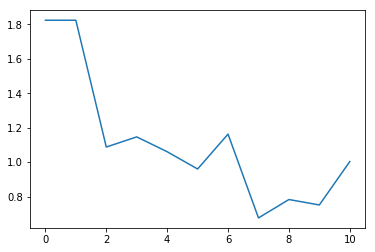

In [137]:
acquisition_function = Acquisition(train_data, init_percent=init_percent, seed=0)
learning_rate = 0.015
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

trainer = Trainer(model, optimizer, result_path, model_name, usedataset=opt.dataset, mappings= mappings)

active_train_data = [train_data[i] for i in acquisition_function.train_index]
tokens_acquired = sum([len(x['words']) for x in active_train_data])

while tokens_acquired < avail_budget:
    
    checkpoint_folder = os.path.join('active_checkpoint',acquire_method, str(tokens_acquired).zfill(8))
    checkpoint_path = os.path.join(result_path, model_name, checkpoint_folder)
    if not os.path.exists(checkpoint_path):
        os.makedirs(checkpoint_path)
        
    losses, all_F = trainer.train_single(1, active_train_data, dev_data, test_train_data, test_data,
                                        learning_rate = learning_rate, checkpoint_folder = checkpoint_folder,
                                        plot_every = len(acquisition_function.train_index)/10,eval_test_train=False)
    
    pkl.dump(acquisition_function, open(os.path.join(checkpoint_path,'acquisition1.p'),'wb'))
    
    acquisition_function.obtain_data(model_path = os.path.join(checkpoint_path ,'modelweights'), model_name = model_name,
                                     data = train_data, acquire = acquire_percent, method='lc')
    
    pkl.dump(acquisition_function, open(os.path.join(checkpoint_path,'acquisition2.p'),'wb'))
    
    active_train_data = [train_data[i] for i in acquisition_function.train_index]
    tokens_acquired = sum([len(x['words']) for x in active_train_data])
    
    print ('*'*80)
    saved_epoch = np.argmax(np.array([item[1] for item in all_F]))
    print ('Budget Exhausted: %d, Best F on Validation %.3f, Best F on Test %.3f' %(tokens_acquired,
                                        all_F[saved_epoch][1], all_F[saved_epoch][2]))
    print ('*'*80)
    
    plt.clf()
    plt.plot(losses)
    plt.savefig(os.path.join(checkpoint_path,'lossplot.png'))